Using device: cpu


Calculating MI: 100%|██████████| 16/16 [1:33:03<00:00, 348.99s/it]


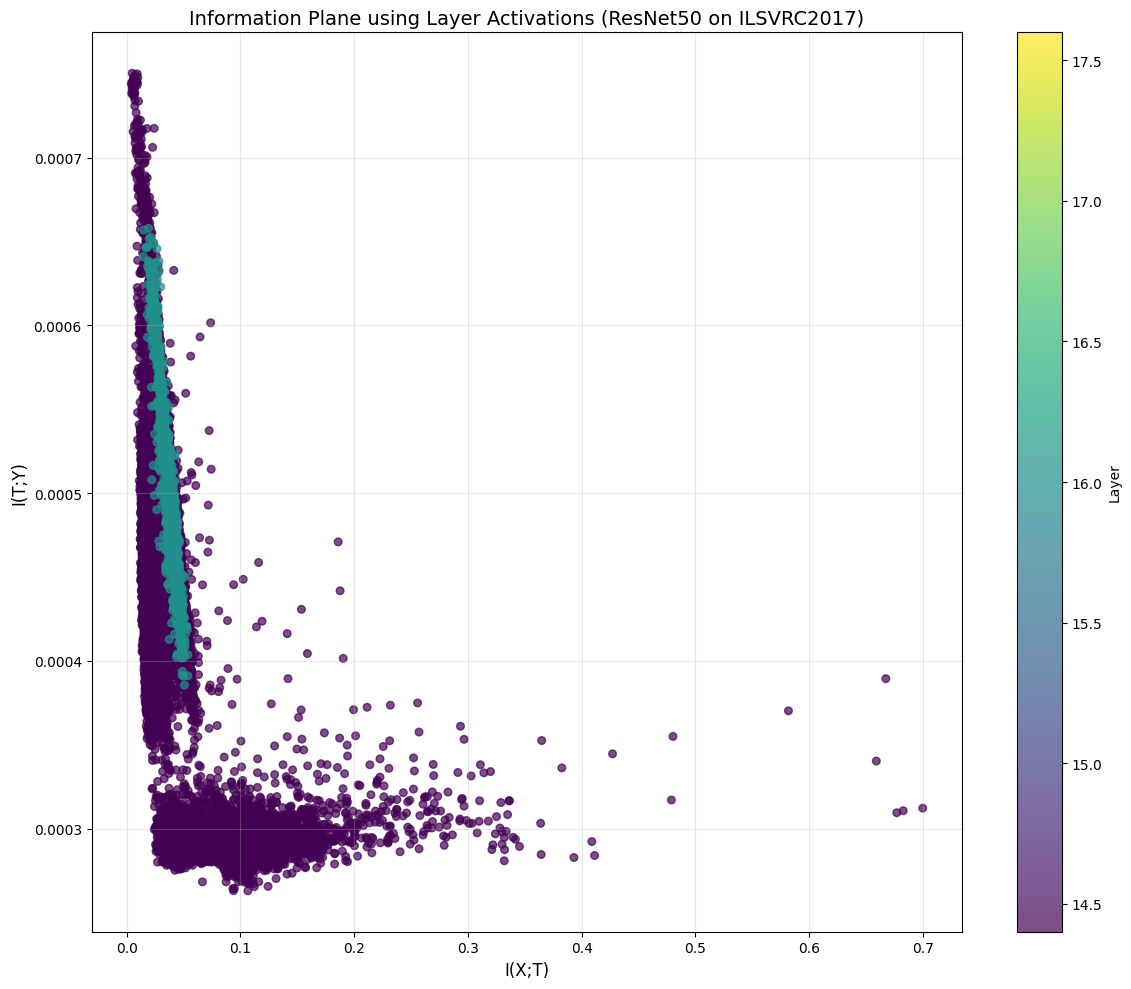

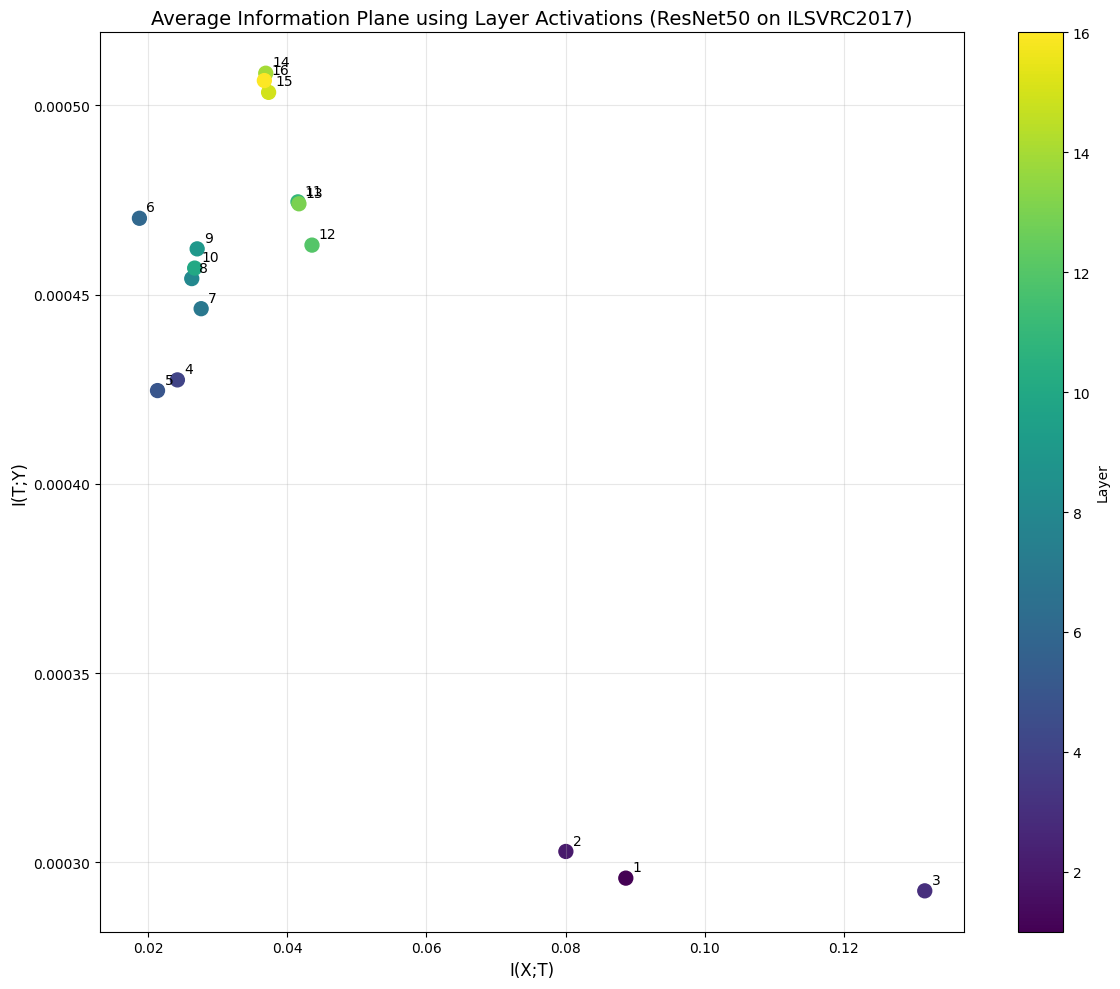

In [1]:
import torch
import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader

# Set device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load pre-trained ResNet50 model
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2).to(device)
model.eval()

# Define transformations
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

class ILSVRC2017Dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = []
        self.labels = []

        for root, _, files in os.walk(root_dir):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.image_files.append(os.path.join(root, file))
                    self.labels.append(os.path.basename(os.path.dirname(os.path.join(root, file))))

        self.label_to_idx = {label: idx for idx, label in enumerate(set(self.labels))}

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.label_to_idx[self.labels[idx]]

        if self.transform:
            image = self.transform(image)

        return image, label

# Load ILSVRC2017 dataset
dataset = ILSVRC2017Dataset(root_dir="../data", transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# Function to resample a tensor
def resample_tensor(tensor, new_size):
    x = np.arange(len(tensor))
    f = interp1d(x, tensor.numpy(), kind='linear')
    x_new = np.linspace(0, len(tensor) - 1, new_size)
    resampled_tensor = f(x_new)
    return torch.tensor(resampled_tensor)

# Function to compute mutual information
def mutual_information(x, y, num_bins=200):
    x = torch.tensor(x) if not isinstance(x, torch.Tensor) else x
    y = torch.tensor(y) if not isinstance(y, torch.Tensor) else y
    
    x = x.flatten()
    y = y.flatten()
    if len(x) != len(y):
        max_len = max(len(x), len(y))
        x = resample_tensor(x, max_len)
        y = resample_tensor(y, max_len)
    x_np = x.numpy()
    y_np = y.numpy()
    joint_hist, x_edges, y_edges = np.histogram2d(x_np, y_np, bins=num_bins)
    
    x_hist = np.histogram(x_np, bins=x_edges)[0]
    y_hist = np.histogram(y_np, bins=y_edges)[0]
    
    p_xy = joint_hist / joint_hist.sum()
    p_x = x_hist / x_hist.sum()
    p_y = y_hist / y_hist.sum()
    
    p_xy = p_xy + 1e-9
    p_x = p_x + 1e-9
    p_y = p_y + 1e-9
    
    mi = np.sum(p_xy * (np.log(p_xy) - np.log(p_x[:, None]) - np.log(p_y[None, :])))
    
    return max(0, mi)

import numpy as np
from scipy.stats import entropy
import matplotlib.pyplot as plt

# Modified Function to get layer activation
def get_layer_activation(model, layer, input_data):
    layers = [model.conv1, model.bn1, model.relu, model.maxpool, 
              *model.layer1, *model.layer2, *model.layer3, *model.layer4]
    activation = input_data
    for i in range(layer + 1):  # +1 to include the current layer
        activation = layers[i](activation)
    return activation

# Select random samples
num_samples = 1000
random_samples = []
random_labels = []

for i, (image, label) in enumerate(dataloader):
    if i >= num_samples:
        break
    random_samples.append(image.to(device))
    random_labels.append(label.item())

# Calculate mutual information for each layer
layers = list(range(1, 17))  # ResNet50 has 16 main layers
mi_x_t = []
mi_t_y = []

model.eval()
with torch.no_grad():
    for layer in tqdm(layers, desc="Calculating MI"):
        layer_mi_x_t = []
        layer_mi_t_y = []
        
        for sample, label in zip(random_samples, random_labels):
            activation = get_layer_activation(model, layer, sample)
            activation = activation.cpu().numpy().flatten()
            
            mi_x_t_sample = mutual_information(sample.cpu().numpy().flatten(), activation)
            mi_t_y_sample = mutual_information(activation, np.array([label]))
            
            layer_mi_x_t.append(mi_x_t_sample)
            layer_mi_t_y.append(mi_t_y_sample)
        
        mi_x_t.append(layer_mi_x_t)
        mi_t_y.append(layer_mi_t_y)

# Plot information plane
plt.figure(figsize=(12, 10))
for i, layer in enumerate(layers):
    scatter = plt.scatter(mi_x_t[i], mi_t_y[i], c=[layer]*num_samples, cmap='viridis', s=30, alpha=0.7)

plt.colorbar(scatter, label='Layer')
plt.xlabel('I(X;T)', fontsize=12)
plt.ylabel('I(T;Y)', fontsize=12)
plt.title('Information Plane using Layer Activations (ResNet50 on ILSVRC2017)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot average information plane
avg_mi_x_t = [np.mean(layer_mi) for layer_mi in mi_x_t]
avg_mi_t_y = [np.mean(layer_mi) for layer_mi in mi_t_y]

plt.figure(figsize=(12, 10))
scatter = plt.scatter(avg_mi_x_t, avg_mi_t_y, c=layers, cmap='viridis', s=100)
plt.colorbar(scatter, label='Layer')

for i, layer in enumerate(layers):
    plt.annotate(str(layer), (avg_mi_x_t[i], avg_mi_t_y[i]), xytext=(5, 5), textcoords='offset points')

plt.xlabel('I(X;T)', fontsize=12)
plt.ylabel('I(T;Y)', fontsize=12)
plt.title('Average Information Plane using Layer Activations (ResNet50 on ILSVRC2017)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [13]:
import pickle
# Save the mutual information to a file
with open("mutual_information.pkl", "wb") as f:
    pickle.dump({"mi_x_t": mi_x_t, "mi_t_y": mi_t_y}, f)

print("Mutual information saved to mutual_info_IP_ResNet1000.pkl")

Mutual information saved to mutual_info_IP_ResNet1000.pkl


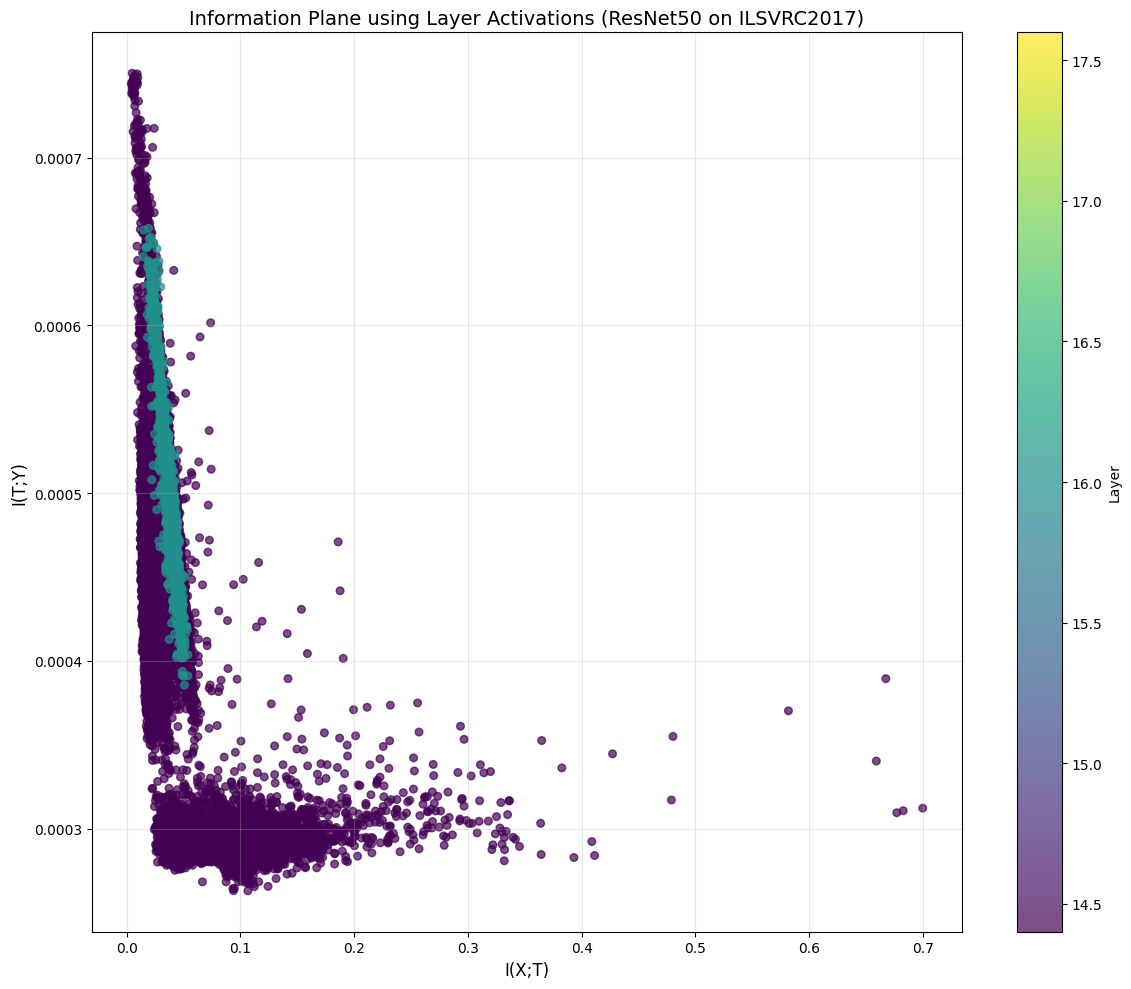

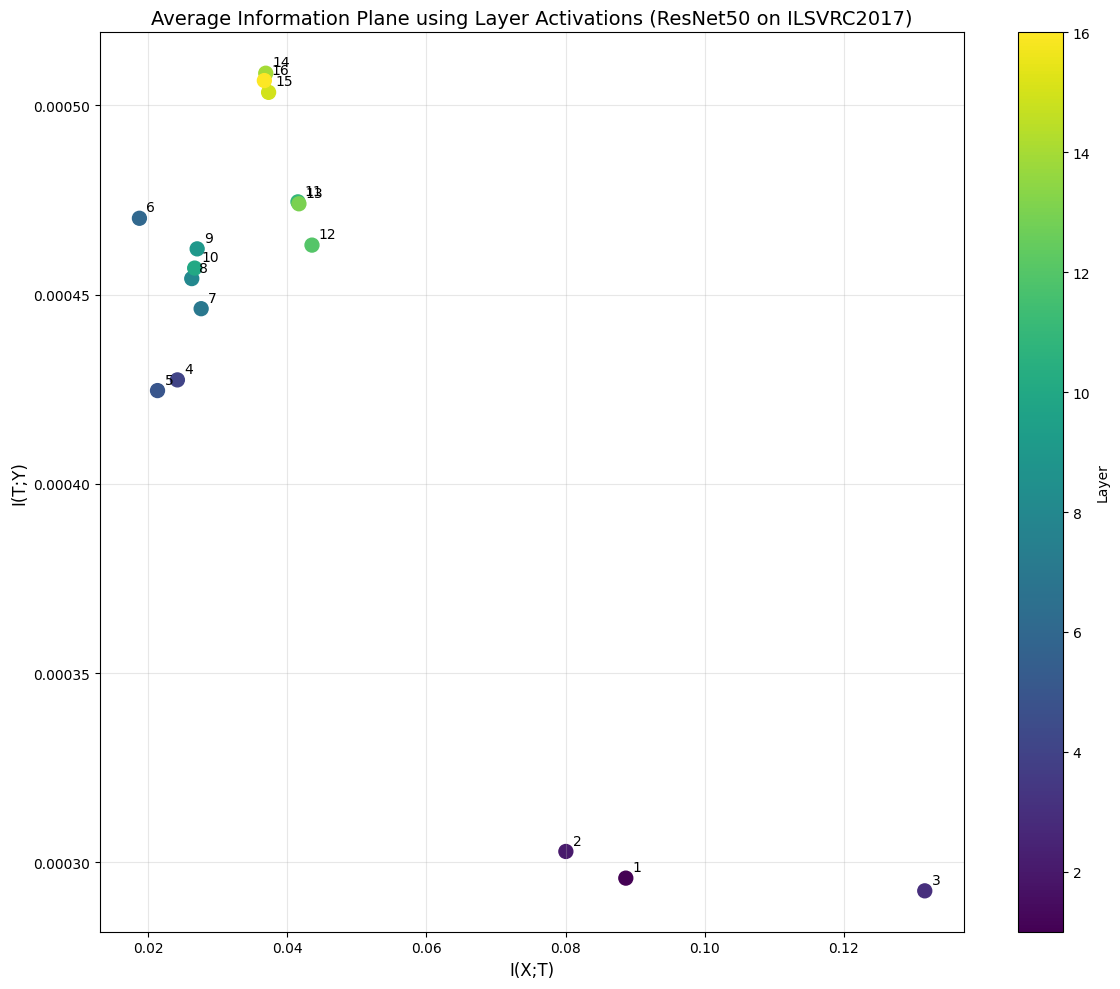

In [8]:
# Plot information plane
plt.figure(figsize=(12, 10))
for i, layer in enumerate(layers):
    scatter = plt.scatter(mi_x_t[i], mi_t_y[i], c=[layer]*num_samples, cmap='viridis', s=30, alpha=0.7)

plt.colorbar(scatter, label='Layer')
plt.xlabel('I(X;T)', fontsize=12)
plt.ylabel('I(T;Y)', fontsize=12)
plt.title('Information Plane using Layer Activations (ResNet50 on ILSVRC2017)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot average information plane
avg_mi_x_t = [np.mean(layer_mi) for layer_mi in mi_x_t]
avg_mi_t_y = [np.mean(layer_mi) for layer_mi in mi_t_y]

plt.figure(figsize=(12, 10))
scatter = plt.scatter(avg_mi_x_t, avg_mi_t_y, c=layers, cmap='viridis', s=100)
plt.colorbar(scatter, label='Layer')

for i, layer in enumerate(layers):
    plt.annotate(str(layer), (avg_mi_x_t[i], avg_mi_t_y[i]), xytext=(5, 5), textcoords='offset points')

plt.xlabel('I(X;T)', fontsize=12)
plt.ylabel('I(T;Y)', fontsize=12)
plt.title('Average Information Plane using Layer Activations (ResNet50 on ILSVRC2017)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

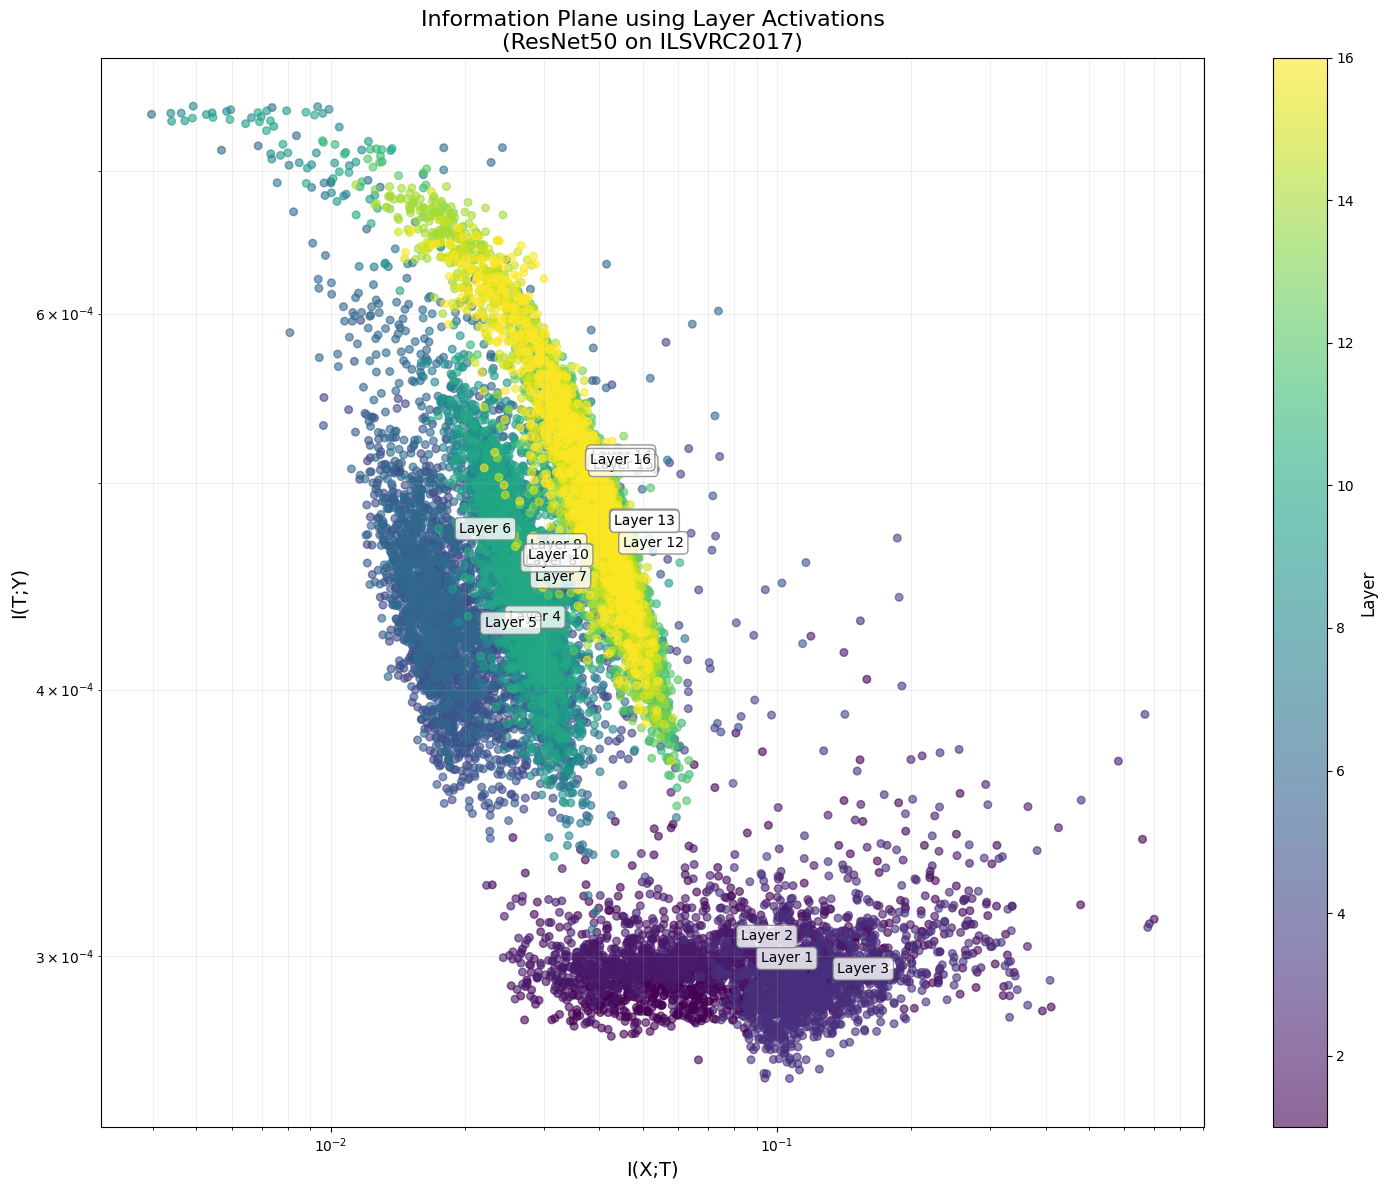

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Préparer les données pour le tracé
all_mi_x_t = [item for sublist in mi_x_t for item in sublist]
all_mi_t_y = [item for sublist in mi_t_y for item in sublist]
all_layers = [layer for layer in layers for _ in range(num_samples)]

# Créer la figure
plt.figure(figsize=(15, 12))

# Tracer tous les points
scatter = plt.scatter(all_mi_x_t, all_mi_t_y, c=all_layers, cmap='viridis', s=30, alpha=0.6)

# Ajouter une barre de couleur
cbar = plt.colorbar(scatter)
cbar.set_label('Layer', fontsize=12)

# Configurer les axes
plt.xscale('log')
plt.yscale('log')
plt.xlabel('I(X;T)', fontsize=14)
plt.ylabel('I(T;Y)', fontsize=14)
plt.title('Information Plane using Layer Activations\n(ResNet50 on ILSVRC2017)', fontsize=16)

# Ajouter une grille
plt.grid(True, which="both", ls="-", alpha=0.2)

# Ajouter des annotations pour chaque couche
for layer in layers:
    layer_mi_x_t = mi_x_t[layer-1]
    layer_mi_t_y = mi_t_y[layer-1]
    mean_x = np.mean(layer_mi_x_t)
    mean_y = np.mean(layer_mi_t_y)
    plt.annotate(f'Layer {layer}', (mean_x, mean_y), xytext=(5, 5), 
                 textcoords='offset points', fontsize=10,
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

plt.tight_layout()
plt.show()

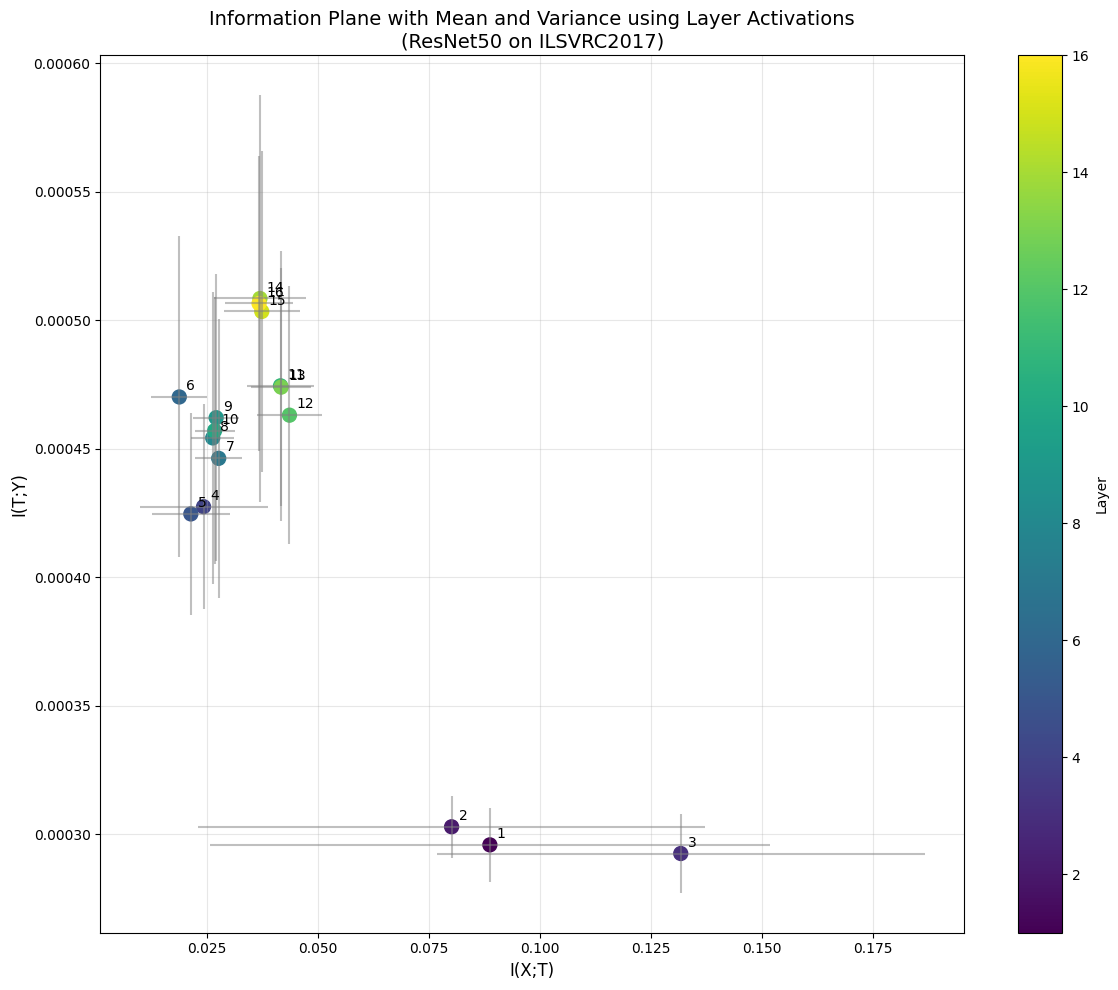

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate mean and standard deviation for each layer
mean_mi_x_t = np.array([np.mean(layer_mi) for layer_mi in mi_x_t])
mean_mi_t_y = np.array([np.mean(layer_mi) for layer_mi in mi_t_y])
std_mi_x_t = np.array([np.std(layer_mi) for layer_mi in mi_x_t])
std_mi_t_y = np.array([np.std(layer_mi) for layer_mi in mi_t_y])

# Create the new figure
plt.figure(figsize=(12, 10))

# Plot error bars
plt.errorbar(mean_mi_x_t, mean_mi_t_y, xerr=std_mi_x_t, yerr=std_mi_t_y, fmt='none', ecolor='gray', alpha=0.5)

# Plot scatter points
scatter = plt.scatter(mean_mi_x_t, mean_mi_t_y, c=layers, cmap='viridis', s=100)
plt.colorbar(scatter, label='Layer')

# Annotate points with layer numbers
for i, layer in enumerate(layers):
    plt.annotate(str(layer), (mean_mi_x_t[i], mean_mi_t_y[i]), xytext=(5, 5), textcoords='offset points')

plt.xlabel('I(X;T)', fontsize=12)
plt.ylabel('I(T;Y)', fontsize=12)
plt.title('Information Plane with Mean and Variance using Layer Activations\n(ResNet50 on ILSVRC2017)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

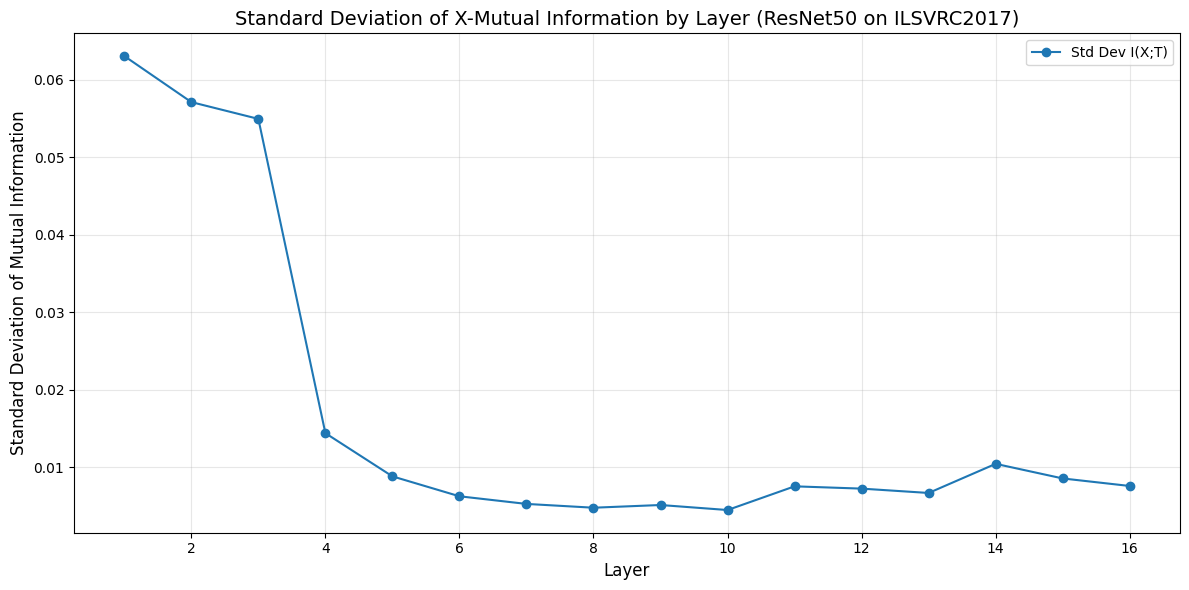

In [11]:
# Calculate mean and standard deviation for each layer
mean_mi_x_t = np.array([np.mean(layer_mi) for layer_mi in mi_x_t])
mean_mi_t_y = np.array([np.mean(layer_mi) for layer_mi in mi_t_y])
std_mi_x_t = np.array([np.std(layer_mi) for layer_mi in mi_x_t])
std_mi_t_y = np.array([np.std(layer_mi) for layer_mi in mi_t_y])

# Create the new figure for standard deviation plot
plt.figure(figsize=(12, 6))

# Plot standard deviation of I(X;T)
plt.plot(layers, std_mi_x_t, label='Std Dev I(X;T)', marker='o')

plt.xlabel('Layer', fontsize=12)
plt.ylabel('Standard Deviation of Mutual Information', fontsize=12)
plt.title('Standard Deviation of X-Mutual Information by Layer (ResNet50 on ILSVRC2017)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


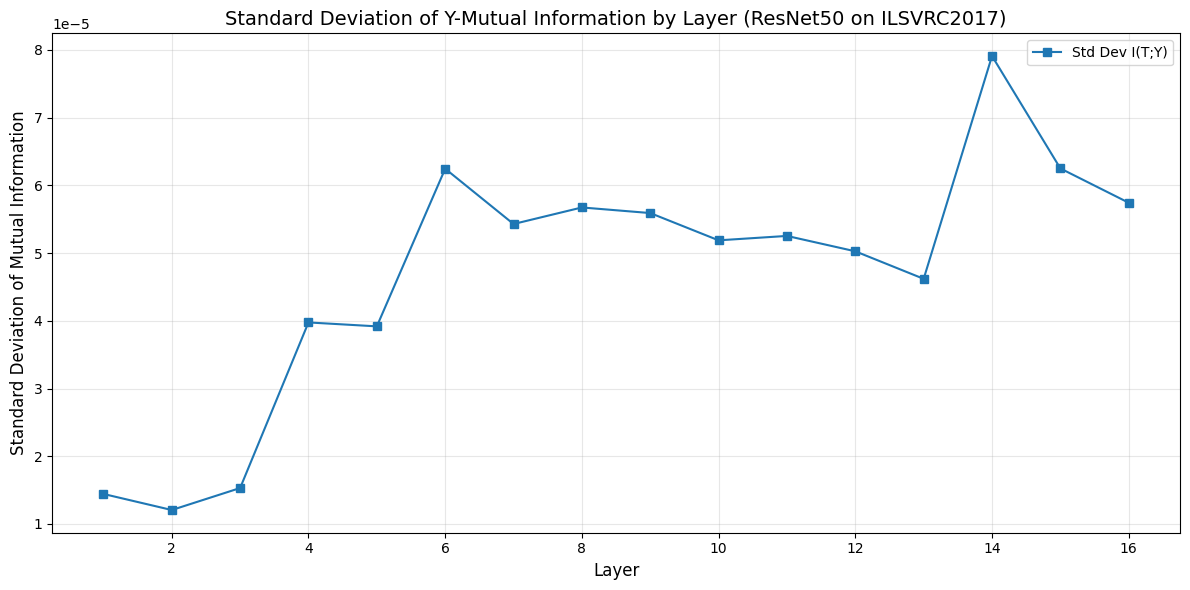

In [12]:
# Calculate mean and standard deviation for each layer
mean_mi_x_t = np.array([np.mean(layer_mi) for layer_mi in mi_x_t])
mean_mi_t_y = np.array([np.mean(layer_mi) for layer_mi in mi_t_y])
std_mi_x_t = np.array([np.std(layer_mi) for layer_mi in mi_x_t])
std_mi_t_y = np.array([np.std(layer_mi) for layer_mi in mi_t_y])

# Create the new figure for standard deviation plot
plt.figure(figsize=(12, 6))

# Plot standard deviation of I(T;Y)
plt.plot(layers, std_mi_t_y, label='Std Dev I(T;Y)', marker='s')

plt.xlabel('Layer', fontsize=12)
plt.ylabel('Standard Deviation of Mutual Information', fontsize=12)
plt.title('Standard Deviation of Y-Mutual Information by Layer (ResNet50 on ILSVRC2017)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()